# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.102941,False,0.018117
1,2.183362,True,9.151580
2,2.639927,True,11.736271
3,1.045403,True,5.571285
4,0.718007,True,6.766273
...,...,...,...
995,-0.581793,False,-1.946845
996,0.147828,True,5.536459
997,0.804175,True,6.434728
998,2.126148,True,8.488784


<Axes: xlabel='v0'>

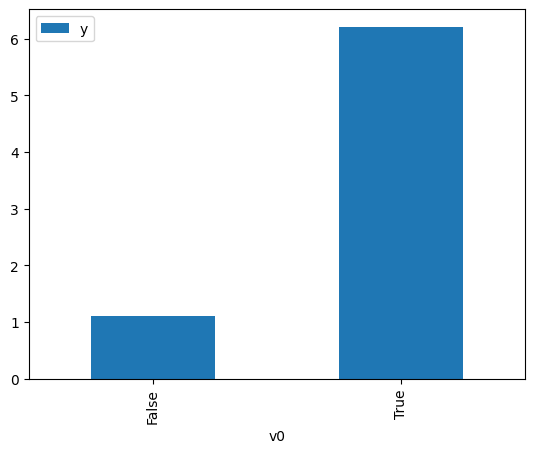

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

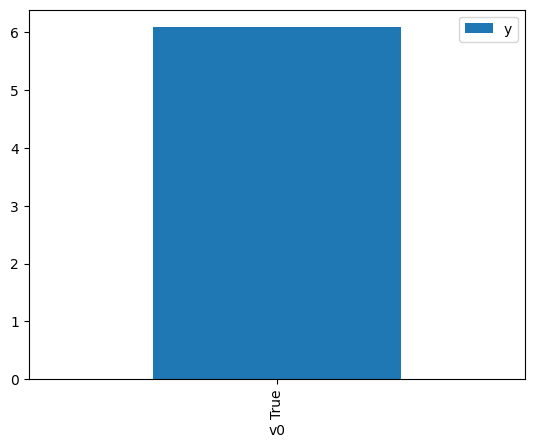

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.205611,False,0.615348,0.529564,1.888347
1,2.851061,False,5.803164,0.044990,22.227121
2,1.231418,False,3.500766,0.202032,4.949706
3,1.500069,False,2.832785,0.160761,6.220410
4,0.122087,False,0.535953,0.444764,2.248381
...,...,...,...,...,...
995,2.667562,False,6.225888,0.053923,18.544791
996,2.571603,False,5.665677,0.059238,16.881025
997,-0.912830,False,-2.068574,0.701130,1.426270
998,1.330428,False,2.434578,0.185966,5.377339


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.294068,True,5.502494,0.447634,2.233969
1,0.556987,True,5.207186,0.662263,1.509974
2,-0.056284,True,6.166709,0.509162,1.964013
3,0.110923,True,5.268255,0.552371,1.810376
4,1.078787,True,4.960749,0.771212,1.296660
...,...,...,...,...,...
995,2.310199,True,8.676777,0.923700,1.082602
996,0.374254,True,5.870991,0.618614,1.616518
997,2.142148,True,9.337365,0.910457,1.098349
998,0.705593,True,8.380255,0.695866,1.437058


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          1.684e+04
Date:                Mon, 04 Sep 2023   Prob (F-statistic):                        0.00
Time:                        06:02:16   Log-Likelihood:                         -1421.0
No. Observations:                1000   AIC:                                      2846.
Df Residuals:                     998   BIC:                                      2856.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1010      0.034     61.624      0.000       2.034       2.168
x2             5.0169      0.050    100.174      0.000       4.919       5.115
==============================================================================
Omnibus:                        4.558   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.474
Skew:                          -0.134   Prob(JB):                        0.107
Kurtosis:                       2.810   Cond. No.                         2.26
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""